In [16]:
import bs4 as bs
import urllib.request
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import re
from geopy.distance import vincenty



In [59]:
RestaurantURL = []
URL = ['https://fi.yelp.fi/search?find_loc=Helsinki&start=0&sortby=rating&attrs=RestaurantsPriceRange2.1,RestaurantsPriceRange2.2,BusinessAcceptsCreditCards,GoodForMeal.breakfast,GoodForMeal.brunch',
       'https://fi.yelp.fi/search?find_loc=Helsinki&start=10&sortby=rating&attrs=RestaurantsPriceRange2.1,RestaurantsPriceRange2.2,BusinessAcceptsCreditCards,GoodForMeal.breakfast,GoodForMeal.brunch']
for i in range(0, len(URL)):
    with urllib.request.urlopen(URL[i]) as url:
        source = url.read()

    soup = bs.BeautifulSoup(source)

    links = soup.find_all("h3",{"class":"search-result-title"})
    #print(links)
    
    restaurantLinks = [tag.a.attrs['href'] for tag in links]

    #print(restaurantLinks)

    for i in range(0, len(restaurantLinks)):
            RestaurantURL.append('https://fi.yelp.fi' + restaurantLinks[i])
#printing the list of URL from scraping             
RestaurantURL

['https://fi.yelp.fi/biz/la-torrefazione-helsinki',
 'https://fi.yelp.fi/biz/caf%C3%A9-engel-helsinki-2',
 'https://fi.yelp.fi/biz/tin-tin-tango-helsinki',
 'https://fi.yelp.fi/biz/ursula-helsinki',
 'https://fi.yelp.fi/biz/story-helsinki',
 'https://fi.yelp.fi/biz/deli-cafe-maya-helsinki',
 'https://fi.yelp.fi/biz/cargo-helsinki-2',
 'https://fi.yelp.fi/biz/block-by-dylan-helsinki',
 'https://fi.yelp.fi/biz/bergga-helsinki',
 'https://fi.yelp.fi/biz/factory-st-gallery-helsinki',
 'https://fi.yelp.fi/biz/picnic-helsinki-18',
 'https://fi.yelp.fi/biz/mcdonalds-helsinki-28']

In [5]:
names = []
credit_card_payment = []
start_price = []
end_price = []
reviews = []
distances = []
ratings = []
addresses = []
saturday = []
sunday = []


for i in range(0, len(RestaurantURL)):
    with urllib.request.urlopen(RestaurantURL[i]) as url:
        restaurantURL = url.read()
    soup = bs.BeautifulSoup(restaurantURL)
    
    #restaurant name 
    restaurant_name = soup.find('div', class_='u-space-t1')
    name = restaurant_name.h1.text.strip()
    names.append(name)

    #card payment possibility 
    card_payment = soup.find('div', class_ ='short-def-list')
    credit1 = card_payment.dd.text.strip()
    credit_card_payment.append(credit1)

    #finding the average price 
    price = soup.find('dd', class_ = 'nowrap price-description').text
    a = re.findall(r"[-+]?\d*\.\d+|\d+", price)
    if len(a)==0:
        start_price.append('')
        end_price.append('')
    elif len(a)==1:
        start_price.append('')
        end_price.append(a[0])
    else:
        start_price.append(a[0])
        end_price.append(a[1])

    #finding the number of review
    review = soup.find('span', class_= 'review-count').text
    r = re.findall(r"[-+]?\d*\.\d+|\d+", review)
    reviews.append(r[0])
    
    #finding the ratings
    rating = soup.find('div', class_ = 'i-stars').attrs['title']
    #s = [float(s) for s in re.findall(r'-?\d+\.?\d*', ratings)]
    s = re.findall(r"[-+]?\d*\.\d+|\d+", rating)
    ratings.append(s[0])
    
    # distance from the restaurant 
    distance = soup.find('div', class_='lightbox-map hidden')
    b = re.findall("\d+\.\d+", str(distance))

    latitude_RES = float(b[0])
    longitude_RES = float(b[1])
    
     # HELSINKI CENTER LOCATION CHECKED FROM THE GOOGLE, MIGHT BE SLIGHTLY DIFFERENT
    latitude_HEL = 60.1696052
    longitude_HEL = 24.937979
    
    HEL = (60.1696052,24.937979)
    RES = (b[0], b[1])                  
    dis = round(vincenty(HEL, RES).km, 2)
    distances.append(dis)
    

    #finding the restaurant address
    address = soup.find('strong', class_='street-address').get_text(separator=u' ').strip()
    addresses.append(address)
    
    

    # finding the weekend opeaning time 
    table = soup.find('table', class_='table table-simple hours-table')
    if table== None:
        saturday.append('')
        sunday.append('')
    else:
        table2 = table.find_all('td')
        saturday1 = table2[10].text.strip()
        sunday1 = table2[12].text.strip()
        saturday.append(saturday1)
        sunday.append(sunday1)
    

In [17]:
# changing the some of the sring to the numeric values
start_price = pd.to_numeric(start_price)
end_price = pd.to_numeric(end_price)
ratings = pd.to_numeric(ratings)
reviews = pd.to_numeric(reviews)

# importing the data into pandas datafame
df = pd.DataFrame()

df['Restaurants']  = pd.Series(names)
df['Credit_Payment'] = pd.Series(credit_card_payment)
df['Lowest_Price'] = pd.Series(start_price)
df['Highest_Price']= pd.Series(end_price)
df['Review'] = pd.Series(reviews)
df['Rating'] = pd.Series(ratings)
df['Distance'] = pd.Series(distances)
df['Address']= pd.Series(addresses)
df['OT_Saturday']= pd.Series(saturday)
df['OT_Sunday']= pd.Series(sunday)

# printing the table 
df

,Restaurants,Credit_Payment,Lowest_Price,Highest_Price,Review,Rating,Distance,Address,OT_Saturday,OT_Sunday
0,La Torrefazione,Kyllä,13.0,21.0,38,4.0,0.33,Aleksanterinkatu 50 00100 Helsinki,09.00 - 19.00,10.00 - 18.30
1,Café Engel,Kyllä,13.0,21.0,29,4.0,0.76,Aleksanterinkatu 26 00170 Helsinki,09.00 - 21.00,10.00 - 19.00
2,Tin Tin Tango,Kyllä,13.0,21.0,28,4.0,1.22,Töölöntorinkatu 7 00260 Helsinki,09.00 - 00.00,10.00 - 21.00
3,Ursula,Kyllä,13.0,21.0,28,4.0,2.05,Ehrenströmintie 3 00140 Helsinki,09.00 - 22.00,09.00 - 18.00
4,Story,Kyllä,13.0,21.0,18,4.0,0.92,Sijaitsee paikassa Vanha kauppahalli,08.00 - 18.00,Suljettu
5,Deli Cafe Maya,Kyllä,NaN,12.0,11,4.0,0.89,Punavuorenkatu 3 00120 Helsinki,Suljettu,11.00 - 15.00
6,Cargo,Kyllä,13.0,21.0,7,4.5,1.13,Ruoholahdenranta 8 Gräsvikskajen 8 00180 Helsinki,10.00 - 22.00,10.00 - 16.00
7,Block by Dylan,Kyllä,13.0,21.0,5,4.0,0.85,Eteläranta 18 00130 Helsinki,10.30 - 16.00,10.30 - 16.00
8,Bergga,Kyllä,NaN,NaN,9,3.5,1.75,Viides linja 14 00530 Helsinki,10.00 - 22.00,10.00 - 20.00
9,Factory St. Gallery,Kyllä,NaN,NaN,5,4.0,1.30,Tehtaankatu 19 00150 Helsinki,10.00 - 17.00,10.00 - 17.00


In [19]:
df.describe()

,Lowest_Price,Highest_Price,Review,Rating,Distance
count,8.0,9.0,12.000000,12.000000,12.000000
mean,13.0,20.0,16.083333,3.791667,0.980833
std,0.0,3.0,11.673267,0.541812,0.565355
min,13.0,12.0,5.000000,2.500000,0.030000
25%,13.0,21.0,6.500000,3.875000,0.705000
50%,13.0,21.0,10.500000,4.000000,0.905000
75%,13.0,21.0,28.000000,4.000000,1.240000
max,13.0,21.0,38.000000,4.500000,2.050000


In [38]:
# restaurant based on the rating 
df.nlargest(5, columns='Rating')

,Restaurants,Credit_Payment,Lowest_Price,Highest_Price,Review,Rating,Distance,Address,OT_Saturday,OT_Sunday
6,Cargo,Kyllä,13.0,21.0,7,4.5,1.13,Ruoholahdenranta 8 Gräsvikskajen 8 00180 Helsinki,10.00 - 22.00,10.00 - 16.00
0,La Torrefazione,Kyllä,13.0,21.0,38,4.0,0.33,Aleksanterinkatu 50 00100 Helsinki,09.00 - 19.00,10.00 - 18.30
1,Café Engel,Kyllä,13.0,21.0,29,4.0,0.76,Aleksanterinkatu 26 00170 Helsinki,09.00 - 21.00,10.00 - 19.00
2,Tin Tin Tango,Kyllä,13.0,21.0,28,4.0,1.22,Töölöntorinkatu 7 00260 Helsinki,09.00 - 00.00,10.00 - 21.00
3,Ursula,Kyllä,13.0,21.0,28,4.0,2.05,Ehrenströmintie 3 00140 Helsinki,09.00 - 22.00,09.00 - 18.00


In [39]:
# restaurant based on the review
best_restarurants = df[df.Review > 15]
best_restarurants.head()

,Restaurants,Credit_Payment,Lowest_Price,Highest_Price,Review,Rating,Distance,Address,OT_Saturday,OT_Sunday
0,La Torrefazione,Kyllä,13.0,21.0,38,4.0,0.33,Aleksanterinkatu 50 00100 Helsinki,09.00 - 19.00,10.00 - 18.30
1,Café Engel,Kyllä,13.0,21.0,29,4.0,0.76,Aleksanterinkatu 26 00170 Helsinki,09.00 - 21.00,10.00 - 19.00
2,Tin Tin Tango,Kyllä,13.0,21.0,28,4.0,1.22,Töölöntorinkatu 7 00260 Helsinki,09.00 - 00.00,10.00 - 21.00
3,Ursula,Kyllä,13.0,21.0,28,4.0,2.05,Ehrenströmintie 3 00140 Helsinki,09.00 - 22.00,09.00 - 18.00
4,Story,Kyllä,13.0,21.0,18,4.0,0.92,Sijaitsee paikassa Vanha kauppahalli,08.00 - 18.00,Suljettu


In [40]:
# Cheapest restaureant 
df.nsmallest(5, 'Highest_Price')

,Restaurants,Credit_Payment,Lowest_Price,Highest_Price,Review,Rating,Distance,Address,OT_Saturday,OT_Sunday
5,Deli Cafe Maya,Kyllä,NaN,12.0,11,4.0,0.89,Punavuorenkatu 3 00120 Helsinki,Suljettu,11.00 - 15.00
0,La Torrefazione,Kyllä,13.0,21.0,38,4.0,0.33,Aleksanterinkatu 50 00100 Helsinki,09.00 - 19.00,10.00 - 18.30
1,Café Engel,Kyllä,13.0,21.0,29,4.0,0.76,Aleksanterinkatu 26 00170 Helsinki,09.00 - 21.00,10.00 - 19.00
2,Tin Tin Tango,Kyllä,13.0,21.0,28,4.0,1.22,Töölöntorinkatu 7 00260 Helsinki,09.00 - 00.00,10.00 - 21.00
3,Ursula,Kyllä,13.0,21.0,28,4.0,2.05,Ehrenströmintie 3 00140 Helsinki,09.00 - 22.00,09.00 - 18.00


In [41]:
# restaurants which are near to the center
df.nsmallest(5, 'Distance')

,Restaurants,Credit_Payment,Lowest_Price,Highest_Price,Review,Rating,Distance,Address,OT_Saturday,OT_Sunday
10,Picnic,Kyllä,NaN,NaN,10,3.0,0.03,"Forum, Kukontori 3. krs Mannerheimintie 20 001...",08.30 - 18.00,Suljettu
0,La Torrefazione,Kyllä,13.0,21.0,38,4.0,0.33,Aleksanterinkatu 50 00100 Helsinki,09.00 - 19.00,10.00 - 18.30
11,McDonald’s,Kyllä,13.0,21.0,5,2.5,0.54,Kluuvi Kluuvikatu 7 00100 Helsinki,,
1,Café Engel,Kyllä,13.0,21.0,29,4.0,0.76,Aleksanterinkatu 26 00170 Helsinki,09.00 - 21.00,10.00 - 19.00
7,Block by Dylan,Kyllä,13.0,21.0,5,4.0,0.85,Eteläranta 18 00130 Helsinki,10.30 - 16.00,10.30 - 16.00


In [53]:
# restaurants which are opened weekened and accept credit card payment
df_filtered1 = df[(df.OT_Saturday != 'Suljettu') & 
                  (df.OT_Sunday != 'Suljettu') & 
                  (df.Credit_Payment == 'Kyllä')]

# filtering with price range 8-21 euro and which has review more than 5
df_filtered2 = df_filtered1[(df_filtered1.Review > 5) & 
                            (df_filtered1.Highest_Price <= 21) & 
                            (df_filtered1.Lowest_Price > 8)]
# printing top 5 restaurants based on above filter
df_filtered2.head()

,Restaurants,Credit_Payment,Lowest_Price,Highest_Price,Review,Rating,Distance,Address,OT_Saturday,OT_Sunday
0,La Torrefazione,Kyllä,13.0,21.0,38,4.0,0.33,Aleksanterinkatu 50 00100 Helsinki,09.00 - 19.00,10.00 - 18.30
1,Café Engel,Kyllä,13.0,21.0,29,4.0,0.76,Aleksanterinkatu 26 00170 Helsinki,09.00 - 21.00,10.00 - 19.00
2,Tin Tin Tango,Kyllä,13.0,21.0,28,4.0,1.22,Töölöntorinkatu 7 00260 Helsinki,09.00 - 00.00,10.00 - 21.00
3,Ursula,Kyllä,13.0,21.0,28,4.0,2.05,Ehrenströmintie 3 00140 Helsinki,09.00 - 22.00,09.00 - 18.00
6,Cargo,Kyllä,13.0,21.0,7,4.5,1.13,Ruoholahdenranta 8 Gräsvikskajen 8 00180 Helsinki,10.00 - 22.00,10.00 - 16.00


In [57]:
# sorting the data based on the review count 

df_final = df_filtered2.nlargest(5, 'Review')
df_final

,Restaurants,Credit_Payment,Lowest_Price,Highest_Price,Review,Rating,Distance,Address,OT_Saturday,OT_Sunday
0,La Torrefazione,Kyllä,13.0,21.0,38,4.0,0.33,Aleksanterinkatu 50 00100 Helsinki,09.00 - 19.00,10.00 - 18.30
1,Café Engel,Kyllä,13.0,21.0,29,4.0,0.76,Aleksanterinkatu 26 00170 Helsinki,09.00 - 21.00,10.00 - 19.00
2,Tin Tin Tango,Kyllä,13.0,21.0,28,4.0,1.22,Töölöntorinkatu 7 00260 Helsinki,09.00 - 00.00,10.00 - 21.00
3,Ursula,Kyllä,13.0,21.0,28,4.0,2.05,Ehrenströmintie 3 00140 Helsinki,09.00 - 22.00,09.00 - 18.00
6,Cargo,Kyllä,13.0,21.0,7,4.5,1.13,Ruoholahdenranta 8 Gräsvikskajen 8 00180 Helsinki,10.00 - 22.00,10.00 - 16.00


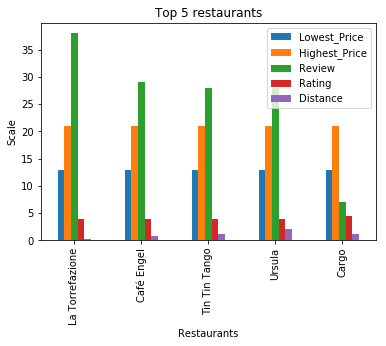

In [58]:
# plotting the the df_final (5 top restaurants based on the review)
df_final.plot(x='Restaurants',kind= 'bar')
plt.title('Top 5 restaurants')
plt.ylabel('Scale')
plt.show()